# 3D-3D Medical Imaging Segmentation, Rigid and Non-Rigid Registration of the Human Chest Using Classical Techniques and CNNs

In [1]:
import os
import numpy as np
# import pydicom
import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns
# import ipyvolume as ipv
import SimpleITK as sitk
# import ipywidgets as widgets

In [2]:
def segment_lung(image):
    # Apply a threshold to separate lung pixels from others
    thresh_filter = sitk.ThresholdImageFilter()
    thresh_filter.SetLower(-1000)
    thresh_filter.SetUpper(-400)
    thresh_img = thresh_filter.Execute(image)
    
    # Apply morphological opening
    morph_filter = sitk.BinaryMorphologicalOpeningImageFilter()
    morph_img = morph_filter.Execute(thresh_img)
    
    # Apply Connected Component Labeling
    cc_filter = sitk.ConnectedComponentImageFilter()
    cc_img = cc_filter.Execute(morph_img)
    
    # Get the two largest components (assumed to be the lungs)
    relabel_filter = sitk.RelabelComponentImageFilter()
    relabel_img = relabel_filter.Execute(cc_img)
    
    # Get labels array
    labels_array = sitk.GetArrayFromImage(relabel_img)
    
    # Count the number of pixels in each region and sort by size
    unique, counts = np.unique(labels_array, return_counts=True)
    sorted_counts = sorted(zip(counts, unique), reverse=True)
    
    # Keep the two largest components (excluding background)
    lung_mask = np.isin(labels_array, [label for _, label in sorted_counts[1:3]])
    
    # Convert to SimpleITK image for further processing
    lung_mask_sitk = sitk.GetImageFromArray(lung_mask.astype(np.uint8))
    lung_mask_sitk.CopyInformation(image)
    
    return lung_mask_sitk  

In [3]:
def segment_bones(image):
    # Convert the SimpleITK image to a numpy array
    image_array = sitk.GetArrayFromImage(image)
    
    # Use thresholding to identify the bones
    # Bones have higher HU than soft tissues or air
    # This range might need adjustment depending on the specific scan
    bone_threshold = 300
    bone_mask = image_array > bone_threshold
    
    # Convert to SimpleITK image for further processing
    bone_mask_sitk = sitk.GetImageFromArray(bone_mask.astype(np.uint8))
    bone_mask_sitk.CopyInformation(image)
    
    return bone_mask_sitk


In [22]:
def load_dicom_series(directory_path):
    reader = sitk.ImageSeriesReader()
#     print(directory_path)
#     dicom_names = files = os.listdir(directory_path).sort()
#     reader.SetFileNames(dicom_names)
    dicom_names = reader.GetGDCMSeriesFileNames(directory_path)
#     print(dicom_names)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    return image


In [5]:
def display_images(image, title, montage_slices=10):
    # Convert the SimpleITK image to a numpy array
    image_array = sitk.GetArrayFromImage(image)
    
    # Normalize to 0-255
    image_array = ((image_array - image_array.min()) * (1/(image_array.max() - image_array.min()) * 255)).astype('uint8')
    
#     # 3D visualization using ipyvolume
#     ipv.figure()
#     ipv.volshow(image_array, level=[0.25, 0.75], opacity=0.03, level_width=0.1, data_min=0, data_max=255)
#     fig3d = ipv.gcc()
    
#     # Create a layout with a title
#     title_widget = widgets.HTML(f'<h2>{title} - 3D View</h2>')
#     layout = widgets.VBox([title_widget, fig3d])
#     display(layout)

    # Montage of slices using matplotlib
    fig = plt.figure(figsize=(10, 2))
    fig.suptitle(title + " - Slice View")
    slice_interval = image_array.shape[0] // montage_slices
    for i in range(montage_slices):
        ax = fig.add_subplot(1, montage_slices, i + 1)
        ax.imshow(image_array[i * slice_interval], cmap='gray')
        plt.axis('off')
    plt.show()

In [6]:
# Loading the Data
data_path = r"SE000003"

# List all files in the directory
files = os.listdir(data_path)
print(files)

# Load the DICOM images
ct_image = load_dicom_series(data_path)

['CT000268', 'CT000408', 'CT000302', 'CT000406', 'CT000371', 'CT000129', 'CT000382', 'CT000102', 'CT000181', 'CT000158', 'CT000280', 'CT000245', 'CT000373', 'CT000420', 'CT000358', 'CT000189', 'CT000266', 'CT000262', 'CT000296', 'CT000144', 'CT000369', 'CT000309', 'CT000075', 'CT000034', 'CT000156', 'CT000308', 'CT000007', 'CT000377', 'CT000090', 'CT000366', 'CT000295', 'CT000345', 'CT000341', 'CT000058', 'CT000297', 'CT000402', 'CT000022', 'CT000190', 'CT000087', 'CT000277', 'CT000149', 'CT000307', 'CT000228', 'CT000363', 'CT000028', 'CT000234', 'CT000164', 'CT000103', 'CT000306', 'CT000109', 'CT000194', 'CT000188', 'CT000148', 'CT000274', 'CT000316', 'CT000134', 'CT000067', 'CT000265', 'CT000081', 'CT000027', 'CT000126', 'CT000387', 'CT000139', 'CT000269', 'CT000042', 'CT000207', 'CT000374', 'CT000173', 'CT000002', 'CT000417', 'CT000206', 'CT000209', 'CT000008', 'CT000210', 'CT000098', 'CT000160', 'CT000355', 'CT000147', 'CT000025', 'CT000248', 'CT000162', 'CT000092', 'CT000151', 'CT

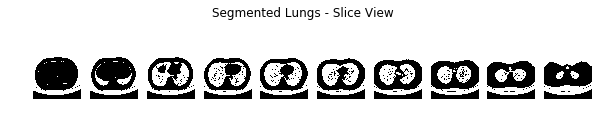

In [7]:
# Perform lung segmentation
lung_mask = segment_lung(ct_image)

# Convert the SimpleITK image to a numpy array for visualization
# lung_mask_array = sitk.GetArrayFromImage(lung_mask)

# Display segmented lungs in 3D
display_images(lung_mask, "Segmented Lungs")

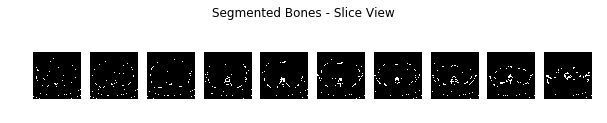

In [8]:
# Perform bone segmentation
bone_mask = segment_bones(ct_image)

## Display the bone segmentation in 3D and slices
display_images(bone_mask, "Segmented Bones")

_______________________

## Initial Alignment

This section of the code provided performs an initial alignment of the images, which is a critical step in the registration process. However, it doesn't directly use organ masks for this process. Instead, it performs the alignment based on the entire image.

In our code, the initial alignment is done using the CenteredTransformInitializer function. This function aligns the centers of the fixed and moving images in the geometrical sense, which can be thought of as a basic form of rigid registration (translating and rotating the source image to align it with the target image).

This initial alignment is crucial because it provides a good starting point for the subsequent optimization process, which refines the transformation parameters to achieve a better alignment. The metric for this optimization is the mean squares difference between the intensities of the fixed and moving images.


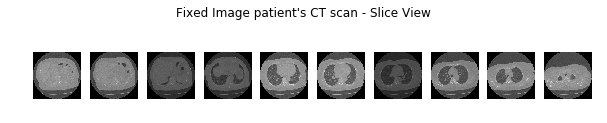

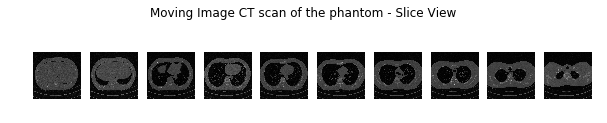

In [23]:
# Paths to the DICOM directories
fixed_image_path = r"manifest-1690161037914/COVID-19-NY-SBU/A042359/12-25-1900-NA-CT CHEST WO IV CONT-15429/4.000000-Lung 1.0-09229"
moving_image_path = r"SE000003"

# Load the DICOM images
fixed_image = load_dicom_series(fixed_image_path)
moving_image = load_dicom_series(moving_image_path)

# Display the images with appropriate titles
display_images(fixed_image, "Fixed Image patient's CT scan")
display_images(moving_image, "Moving Image CT scan of the phantom")

In [28]:
# Apply the transformation
registration_method = sitk.ImageRegistrationMethod()
# registration_method.SetMetricAsMeanSquares()
registration_method.SetMetricAsCorrelation()
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetInterpolator(sitk.sitkLinear)

initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

registration_method.SetInitialTransform(initial_transform, inPlace=False)
final_transform_v1 = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                 sitk.Cast(moving_image, sitk.sitkFloat32))

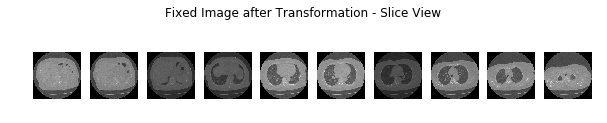

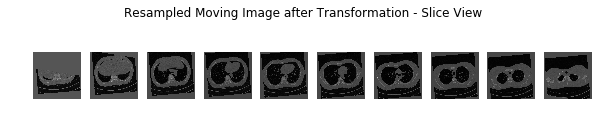

In [29]:
# Resample the moving image onto the fixed image's grid
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed_image)
resampler.SetTransform(final_transform_v1)
resampled_moving_image = resampler.Execute(moving_image)

# Display the images after transformation
display_images(fixed_image, "Fixed Image after Transformation")
display_images(resampled_moving_image, "Resampled Moving Image after Transformation")

______________________

## Deformable Registration  


This section of our code includes a deformable registration phase using B-spline Free-Form Deformation. This approach treats the transformation as a smooth displacement field where control points influence the deformation of a region around them. In this case, I'll use the B-spline transform to create the displacement field and optimize it based on the Mean Squares metric.

The general approach to deformable registration in SimpleITK involves setting up an ImageRegistrationMethod with a BSplineTransformInitializer. The parameters of this initial B-spline transform are then optimized during the registration process to achieve the best alignment.

In [ ]:
# # Apply the affine transformation
# affine_registration_method = sitk.ImageRegistrationMethod()
# # affine_registration_method.SetMetricAsMeanSquares()
# affine_registration_method.SetMetricAsCorrelation()
# affine_registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
# affine_registration_method.SetInterpolator(sitk.sitkLinear)

# initial_affine_transform = sitk.CenteredTransformInitializer(fixed_image, 
#                                                               moving_image, 
#                                                               sitk.Euler3DTransform(), 
#                                                               sitk.CenteredTransformInitializerFilter.GEOMETRY)

# affine_registration_method.SetInitialTransform(initial_affine_transform, inPlace=False)
# final_affine_transform = affine_registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
#                                                              sitk.Cast(moving_image, sitk.sitkFloat32))

In [ ]:
# Now set up the deformable registration (B-spline)
deformable_registration_method = sitk.ImageRegistrationMethod()
# deformable_registration_method.SetMetricAsMeanSquares()
deformable_registration_method.SetMetricAsCorrelation()
deformable_registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5, numberOfIterations=100)
deformable_registration_method.SetInterpolator(sitk.sitkLinear)

# Initialize the B-spline transform
transform_domain_physical_dim_size = fixed_image.GetSize()
transform_domain_mesh_size = [size//8 for size in transform_domain_physical_dim_size] # Arbitrary mesh size, you might need to adjust this
initial_deformable_transform = sitk.BSplineTransformInitializer(image1=fixed_image, 
                                                                transformDomainMeshSize=transform_domain_mesh_size, order=3)

deformable_registration_method.SetInitialTransform(initial_deformable_transform)
final_deformable_transform = deformable_registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                                    sitk.Cast(resampled_moving_image, sitk.sitkFloat32))

In [ ]:
# Combine the affine and deformable transforms
composite_transform = sitk.Transform(fixed_image.GetDimension(), sitk.sitkComposite)
composite_transform.AddTransform(final_transform_v1)
composite_transform.AddTransform(final_deformable_transform)

# Resample the moving image onto the fixed image's grid using the composite transform
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed_image)
resampler.SetTransform(composite_transform)
resampled_moving_image = resampler.Execute(moving_image)

# Display the images after transformation
display_images(fixed_image, "Fixed Image after Transformation")
display_images(resampled_moving_image, "Resampled Moving Image after Transformation")

______________________________________

 ## Deep learning-based Deformable registration methods using neural networks to learn the transformation between images.

In [ ]:
# import os
# import torch
# import numpy as np
# import SimpleITK as sitk
# from torch.utils.data import Dataset, DataLoader
# from scipy.ndimage import map_coordinates
# import voxelmorph as vxm  # make sure to install the voxelmorph package

# # Load a pretrained model
# model = vxm.networks.VxmDense()
# model.load_weights('path_to_your_pretrained_model.h5')

# class CTScanDataset(Dataset):
#     def __init__(self, directory_path):
#         self.files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.dcm')]

#     def __len__(self):
#         return len(self.files)

#     def __getitem__(self, idx):
#         # Use SimpleITK to read the DICOM file
#         image = sitk.ReadImage(self.files[idx])

#         # Convert the image to a numpy array
#         image_array = sitk.GetArrayFromImage(image)

#         # Rescale the intensities to the range [0, 1]
#         image_array = (image_array - image_array.min()) / (image_array.max() - image_array.min())

#         return image_array

# def preprocess(image_array):
#     # Add extra dimension for channels
#     image_array = image_array[np.newaxis, ...]

#     # Convert the numpy array to a PyTorch tensor
#     image_tensor = torch.from_numpy(image_array)

#     return image_tensor

# def apply_displacement_field(moving_image_array, displacement_field):
#     # Create a grid of coordinates
#     coords = np.mgrid[0:moving_image_array.shape[0], 0:moving_image_array.shape[1], 0:moving_image_array.shape[2]]

#     # Add the displacement field to the coordinates
#     coords += displacement_field

#     # Use map_coordinates to apply the displacement field
#     warped_moving_image_array = map_coordinates(moving_image_array, coords, order=3)

#     return warped_moving_image_array

# def display_images(image_array):
#     ipv.figure()
#     ipv.volshow(image_array, level=[0.25, 0.75], opacity=0.03, level_width=0.1, data_min=0, data_max=255)
#     ipv.show()

# # Paths to the DICOM directories
# fixed_image_path = r"C:\Users\HP\Documents\GitHub\3D-3D_Image_Registration\SE000003"
# moving_image_path = r"C:\Users\HP\Documents\GitHub\3D-3D_Image_Registration\SE000003"

# # Load the DICOM images
# fixed_image = CTScanDataset(fixed_image_path)
# moving_image = CTScanDataset(moving_image_path)

# # Convert to tensors
# fixed_image_tensor = preprocess(fixed_image[0])  # Assume there's one 3D image per directory
# moving_image_tensor = preprocess(moving_image[0])  # Assume there's one 3D image per directory

# # Pass images through model to get displacement field
# displacement_field = model.predict([fixed_image_tensor.float().unsqueeze(0), moving_image_tensor.float().unsqueeze(0)])

# # Convert displacement field back to numpy
# displacement_field = displacement_field.detach().numpy()

# # Apply displacement field to moving image
# warped_moving_image_array = apply_displacement_field(moving_image_tensor.numpy(), displacement_field)

# # Display the images after transformation
# display_images(fixed_image[0])
# display_images(warped_moving_image_array)
